In [129]:
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio import AlignIO
from Bio.Align.Applications import ClustalwCommandline
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from Bio.Phylo import Consensus


`clustalw2 -INFILE=sequences_readable.fasta -OUTFILE=aligned_sequences.fasta -OUTPUT=FASTA`

### 0. Make separate groups

#### clean general

In [130]:
def normalize_first_word(word):
    first_part = word.split("-")[0].lower()  
    if first_part in ['albumin', 'serum']:
        return 'albumin'  # Normalize both to 'albumin_serum'
    if first_part in ['cathepsin', 'hypothetical']:
        return 'cathepsin'
    return first_part

In [131]:
input_file = "preprocessed_data/aligned_sequences.fasta"
output_file = "preprocessed_data/aligned_sequences_clean.fasta"


with open(input_file, "r") as infile, open(output_file, "w") as outfile:
    current_id = None
    current_seq = []
    
    for line in infile:
        if line.startswith(">"):
            if current_id:
                parts = current_id.split("_")
                protein_name = normalize_first_word(parts[0])
                species_name = "_".join(parts[1:])  
                normalized_id = f"{protein_name}_{species_name}"
                
                outfile.write(f">{normalized_id}\n")
                for i in range(0, len("".join(current_seq)), 60): 
                    outfile.write("".join(current_seq)[i:i+60] + "\n")
            
            current_id = line[1:].strip()
            current_seq = []
        else:
            current_seq.append(line.strip())
    
    if current_id:
        parts = current_id.split("_")
        protein_name = normalize_first_word(parts[0])
        species_name = "_".join(parts[1:])  
        normalized_id = f"{protein_name}_{species_name}"
        
        outfile.write(f">{normalized_id}\n")
        for i in range(0, len("".join(current_seq)), 60):  
            outfile.write("".join(current_seq)[i:i+60] + "\n")

print(f"Cleaned file written to {output_file}")


Cleaned file written to preprocessed_data/aligned_sequences_clean.fasta


#### species

In [132]:
input_file = "preprocessed_data/aligned_sequences_clean.fasta"
output_dir = "preprocessed_data/groups_species/"  # Directory to store the output files

groups = defaultdict(list)

with open(input_file, "r") as infile:
    current_id = None
    current_seq = []
    
    for line in infile:
        if line.startswith(">"):
            if current_id:
                key = "_".join(current_id.split("_")[-2:])
                groups[key].append((current_id, "".join(current_seq)))
            
            current_id = line[1:].strip()
            current_seq = []
        else:
            current_seq.append(line.strip())
    
    if current_id:
        key = "_".join(current_id.split("_")[-2:])
        groups[key].append((current_id, "".join(current_seq)))

os.makedirs(output_dir, exist_ok=True)

for key, sequences in groups.items():
    output_file = os.path.join(output_dir, f"{key}.fasta")
    with open(output_file, "w") as outfile:
        for seq_id, seq in sequences:
            outfile.write(f">{seq_id}\n")
            for i in range(0, len(seq), 60):  # Wrap sequence to 60 characters per line
                outfile.write(seq[i:i+60] + "\n")

print(f"Files written to {output_dir}")


Files written to preprocessed_data/groups_species/


#### protein

In [133]:

input_file = "preprocessed_data/aligned_sequences_clean.fasta"
output_dir = "preprocessed_data/groups_proteins/"  # Directory to store the output files

groups = defaultdict(list)

with open(input_file, "r") as infile:
    current_id = None
    current_seq = []
    
    for line in infile:
        if line.startswith(">"):
            if current_id:
                first_word = normalize_first_word(current_id.split("_")[0])
                groups[first_word].append((current_id, "".join(current_seq)))
            
            current_id = line[1:].strip()
            current_seq = []
        else:
            current_seq.append(line.strip())
    
    if current_id:
        first_word = normalize_first_word(current_id.split("_")[0])
        groups[first_word].append((current_id, "".join(current_seq)))

os.makedirs(output_dir, exist_ok=True)

for key, sequences in groups.items():
    output_file = os.path.join(output_dir, f"{key}.fasta")
    with open(output_file, "w") as outfile:
        for seq_id, seq in sequences:
            outfile.write(f">{seq_id}\n")
            for i in range(0, len(seq), 60): 
                outfile.write(seq[i:i+60] + "\n")

print(f"Files written to {output_dir}")


Files written to preprocessed_data/groups_proteins/


### 1.1 Separate tree for each "group" of proteins

In [134]:
input_dir = "preprocessed_data/groups_proteins/"
output_dir = "results/protein_trees/"

os.makedirs(output_dir, exist_ok=True)  

fasta_files = [f for f in os.listdir(input_dir) if f.endswith(".fasta")]

for fasta_file in fasta_files:
    alignment = AlignIO.read(os.path.join(input_dir, fasta_file), "fasta")
    
    calculator = DistanceCalculator('blastp')  
    distance_matrix = calculator.get_distance(alignment)
    
    constructor = DistanceTreeConstructor()
    tree = constructor.nj(distance_matrix)
    
    Phylo.write(tree, f"trees/proteins/{fasta_file.split('.')[0]}.nwk", "newick")
    
    fig, ax = plt.subplots(figsize=(20, 15))  
    Phylo.draw(tree, do_show=False, axes=ax)
    
    output_file = os.path.join(output_dir, f"{fasta_file}_tree.png")
    plt.savefig(output_file) 
    plt.close(fig)  
    
    print(f"Tree for {fasta_file} saved as {output_file}")


Tree for chymotrypsin.fasta saved as results/protein_trees/chymotrypsin.fasta_tree.png
Tree for albumin.fasta saved as results/protein_trees/albumin.fasta_tree.png
Tree for prothrombin.fasta saved as results/protein_trees/prothrombin.fasta_tree.png
Tree for cathepsin.fasta saved as results/protein_trees/cathepsin.fasta_tree.png
Tree for galectin.fasta saved as results/protein_trees/galectin.fasta_tree.png
Tree for gastricsin.fasta saved as results/protein_trees/gastricsin.fasta_tree.png
Tree for lactase.fasta saved as results/protein_trees/lactase.fasta_tree.png
Tree for cytochrome.fasta saved as results/protein_trees/cytochrome.fasta_tree.png


### 1.2 For clustered groups (species)

In [135]:
input_dir = "preprocessed_data/groups_species/"
output_dir = "results/species_trees/"

os.makedirs(output_dir, exist_ok=True)  

fasta_files = [f for f in os.listdir(input_dir) if f.endswith(".fasta")]

for fasta_file in fasta_files:
    alignment = AlignIO.read(os.path.join(input_dir, fasta_file), "fasta")
    
    calculator = DistanceCalculator('blastp')  
    distance_matrix = calculator.get_distance(alignment)
    
    constructor = DistanceTreeConstructor()
    tree = constructor.nj(distance_matrix)
    
    Phylo.write(tree, f"trees/species/{fasta_file.split('.')[0]}.nwk", "newick")
    
    fig, ax = plt.subplots(figsize=(20, 15))  
    Phylo.draw(tree, do_show=False, axes=ax)
    
    
    output_file = os.path.join(output_dir, f"{fasta_file}_tree.png")
    plt.savefig(output_file)  
    plt.close(fig) 
    
    print(f"Tree for {fasta_file} saved as {output_file}")


Tree for Callithrix_jacchus.fasta saved as results/species_trees/Callithrix_jacchus.fasta_tree.png
Tree for Papio_anubis.fasta saved as results/species_trees/Papio_anubis.fasta_tree.png
Tree for Rhinopithecus_roxellana.fasta saved as results/species_trees/Rhinopithecus_roxellana.fasta_tree.png
Tree for Macaca_fascicularis.fasta saved as results/species_trees/Macaca_fascicularis.fasta_tree.png
Tree for Trachypithecus_francoisi.fasta saved as results/species_trees/Trachypithecus_francoisi.fasta_tree.png
Tree for Homo_sapiens.fasta saved as results/species_trees/Homo_sapiens.fasta_tree.png
Tree for Aotus_nancymaae.fasta saved as results/species_trees/Aotus_nancymaae.fasta_tree.png


### 1.3 One common tree for all downloaded sequences

In [136]:
alignment = AlignIO.read("preprocessed_data/aligned_sequences_clean.fasta", "fasta")

calculator = DistanceCalculator('blastp')  
distance_matrix = calculator.get_distance(alignment)

constructor = DistanceTreeConstructor()
tree = constructor.nj(distance_matrix)

Phylo.write(tree, f"trees/common_tree.nwk", "newick")

1

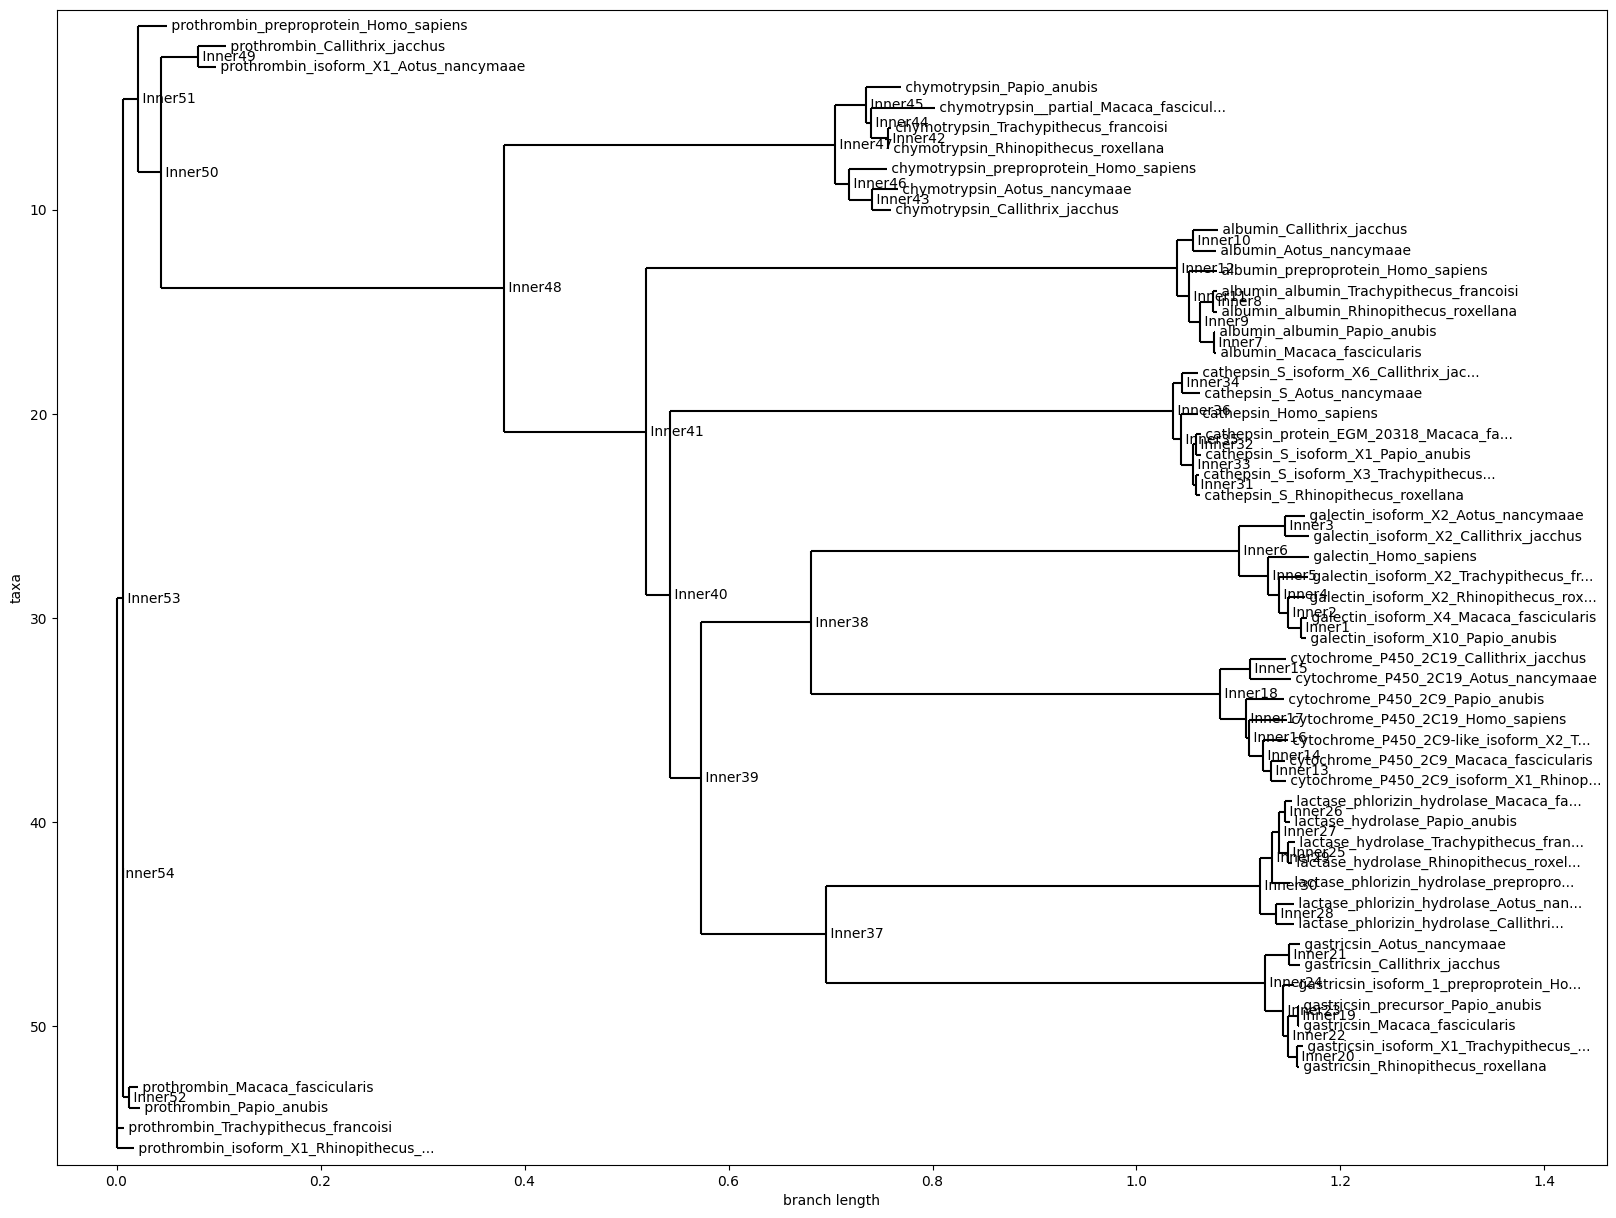

In [137]:
fig, ax = plt.subplots(figsize=(20, 15)) 
Phylo.draw(tree, do_show=False, axes=ax)

plt.savefig("results/common_tree.png")  
plt.show() 

###  2.  Create consensus trees

#### species

In [138]:
tree_folder = "trees/species"  

tree_files = [f for f in os.listdir(tree_folder) if f.endswith(".nwk")]  

trees = []

for tree_file in tree_files:
    tree_path = os.path.join(tree_folder, tree_file)
    print(tree_path)
    tree = Phylo.read(tree_path, "newick")  
    trees.append(tree)

trees/species/Papio_anubis.nwk
trees/species/Aotus_nancymaae.nwk
trees/species/Homo_sapiens.nwk
trees/species/Macaca_fascicularis.nwk
trees/species/Callithrix_jacchus.nwk
trees/species/Trachypithecus_francoisi.nwk
trees/species/Rhinopithecus_roxellana.nwk


In [139]:
consensus_tree = Consensus.majority_consensus(trees)

Phylo.write(consensus_tree, f"trees/consensus_tree_species.nwk", "newick")

fig, ax = plt.subplots(figsize=(20, 15))  
Phylo.draw(consensus_tree, do_show=False, axes=ax)

output_file = "results/species_consensus_tree.png"
plt.savefig(output_file)
plt.close(fig)

print(f"Consensus tree saved as '{output_file}'")

Consensus tree saved as 'results/species_consensus_tree.png'


### proteins

In [140]:
tree_folder = "trees/proteins" 

tree_files = [f for f in os.listdir(tree_folder) if f.endswith(".nwk")]  

trees = []

for tree_file in tree_files:
    tree_path = os.path.join(tree_folder, tree_file)
    print(tree_path)
    tree = Phylo.read(tree_path, "newick") 
    trees.append(tree)

trees/proteins/chymotrypsin.nwk
trees/proteins/prothrombin.nwk
trees/proteins/lactase.nwk
trees/proteins/galectin.nwk
trees/proteins/albumin.nwk
trees/proteins/cathepsin.nwk
trees/proteins/gastricsin.nwk
trees/proteins/cytochrome.nwk


In [141]:
consensus_tree = Consensus.majority_consensus(trees)

Phylo.write(consensus_tree, f"trees/consensus_tree_proteins.nwk", "newick")

fig, ax = plt.subplots(figsize=(20, 15))  
Phylo.draw(consensus_tree, do_show=False, axes=ax)

output_file = "results/proteins_consensus_tree.png"
plt.savefig(output_file)
plt.close(fig)

print(f"Consensus tree saved as '{output_file}'")

Consensus tree saved as 'results/proteins_consensus_tree.png'


### 3. Color the trees

In [142]:
organism_colors = {
    "Aotus_nancymaae": "blue",
    "Callithrix_jacchus": "green",
    "Macaca_fascicularis": "red",
    "Papio_anubis": "purple",
    "Rhinopithecus_roxellana": "orange",
    "Trachypithecus_francoisi": "magenta",
    "Homo_sapiens": "cyan",
    "other": "gray"  
}

In [143]:
protein_group_colors = {
    "chymotrypsin": "blue",
    "lactase": "green",
    "cytochrome": "red",
    "albumin": "purple",
    "prothrombin": "orange",
    "cathepsin": "fuchsia",
    "gastricsin": "cyan",
    "galectin": "magenta",
    "other": "gray"  
}

In [144]:
def get_color(name, color_mapping):
    if name is None:  
        return "gray"  
    if not name.startswith('Inner'):  
        if color_mapping == organism_colors:
            key = '_'.join(name.split("_")[-2:])
        else:
            key = name.split("_")[0]  
            key = key.split("-")[0]
    else:
        key = name
    return color_mapping.get(key, "gray")  

In [145]:
from Bio import Phylo
import matplotlib.pyplot as plt

def color_tree(tree, output_file, color_mapping, figsize=(20, 15)):

    fig, ax = plt.subplots(figsize=figsize)

    for clade in tree.find_clades():
        color = get_color(clade.name, color_mapping)
        clade.color = color  

    Phylo.draw(tree, axes=ax, do_show=False)

    plt.savefig(output_file)
    plt.show()
    plt.close(fig)
    print(f"Tree saved to {output_file}")


In [146]:
all_sequences_tree = Phylo.read("trees/common_tree.nwk", "newick")
species_consensus_tree = Phylo.read("trees/consensus_tree_species.nwk", "newick")
proteins_consensus_tree = Phylo.read("trees/consensus_tree_proteins.nwk", "newick")

### organisms

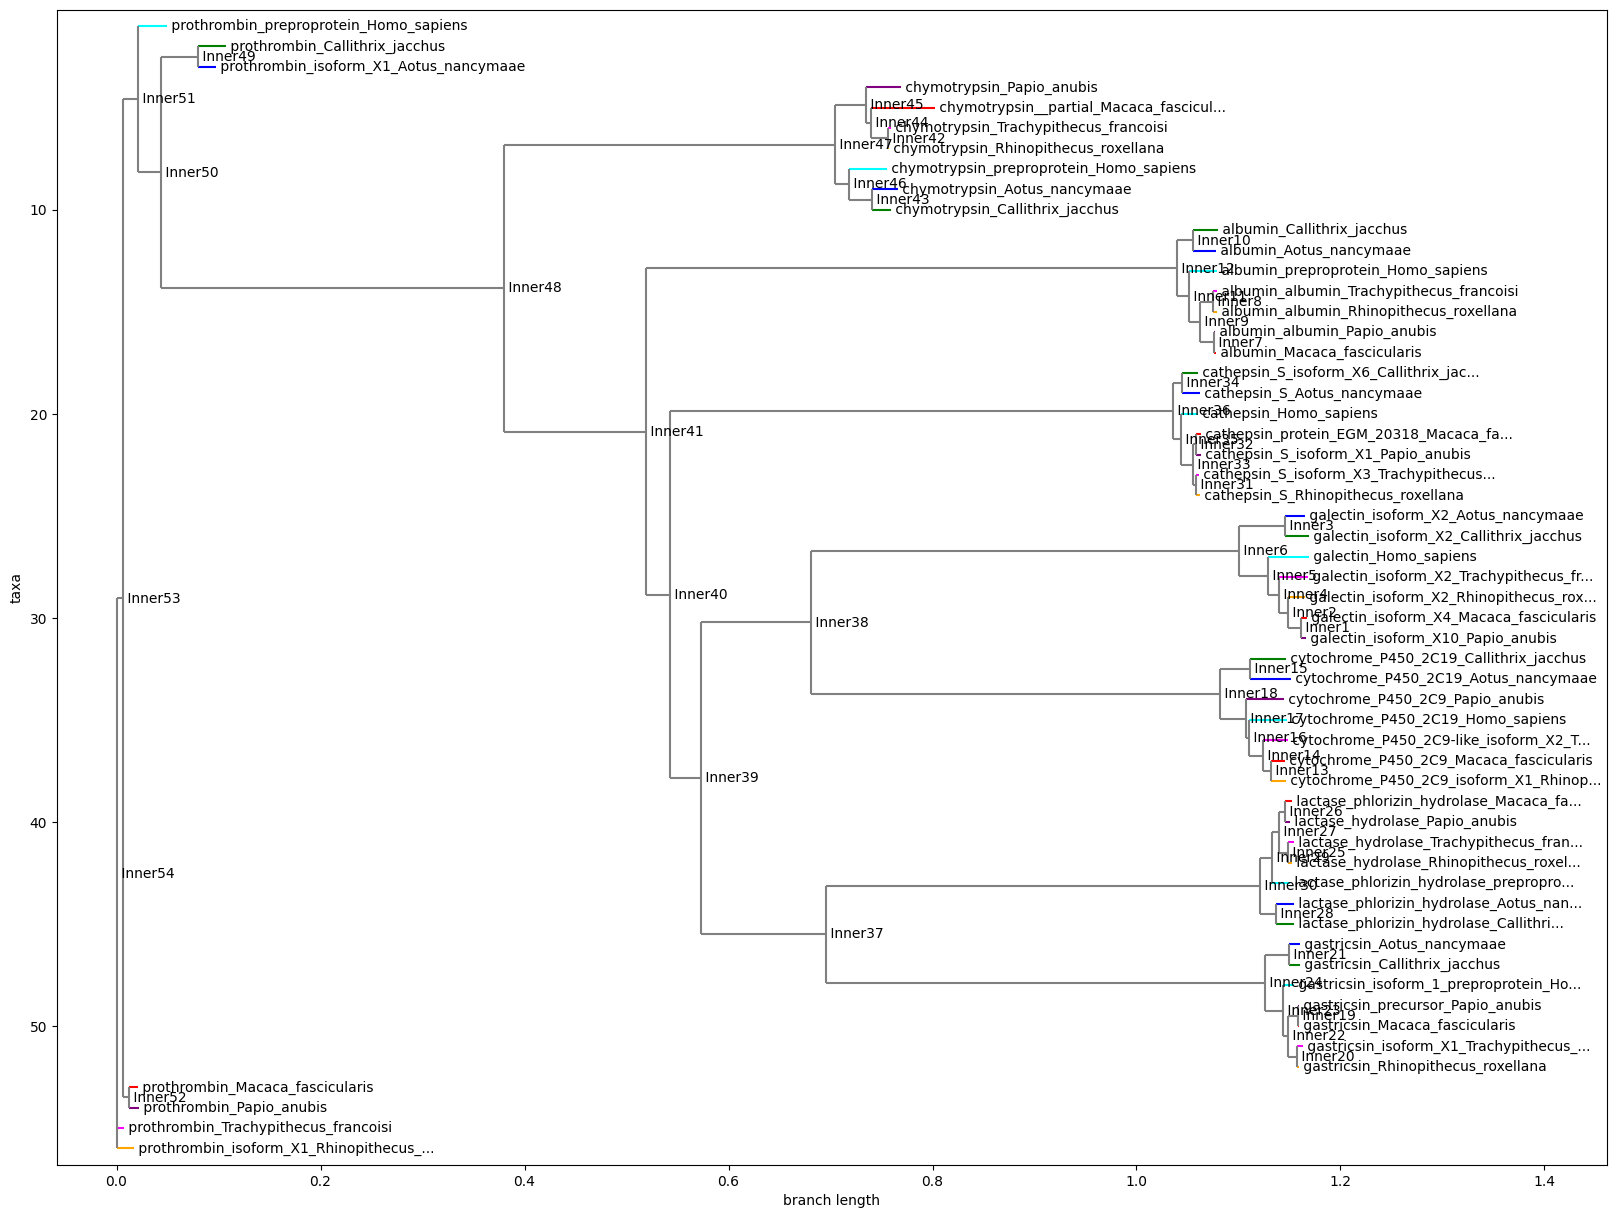

Tree saved to results/all_sequences_colored_by_organism.png


In [147]:
color_tree(all_sequences_tree, "results/all_sequences_colored_by_organism.png", organism_colors)

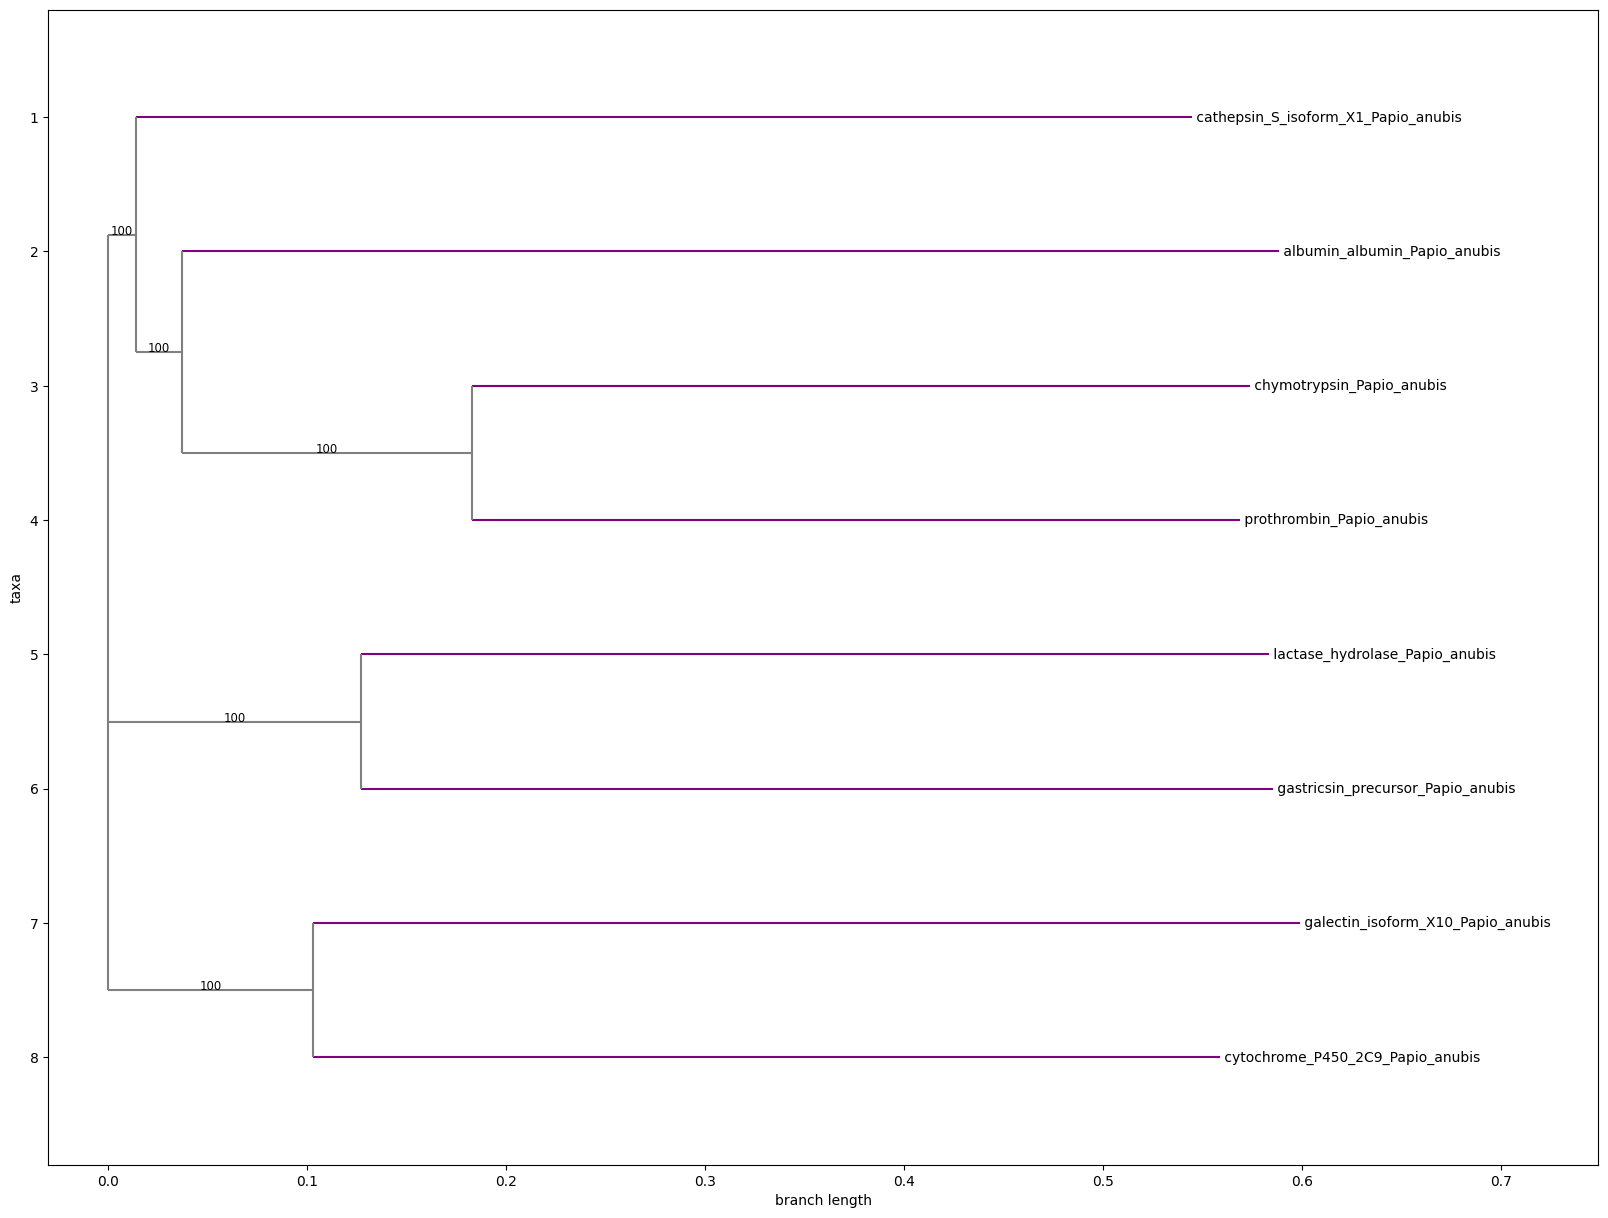

Tree saved to results/species_consensus_colored_by_organism.png


In [148]:
color_tree(species_consensus_tree, "results/species_consensus_colored_by_organism.png", organism_colors)

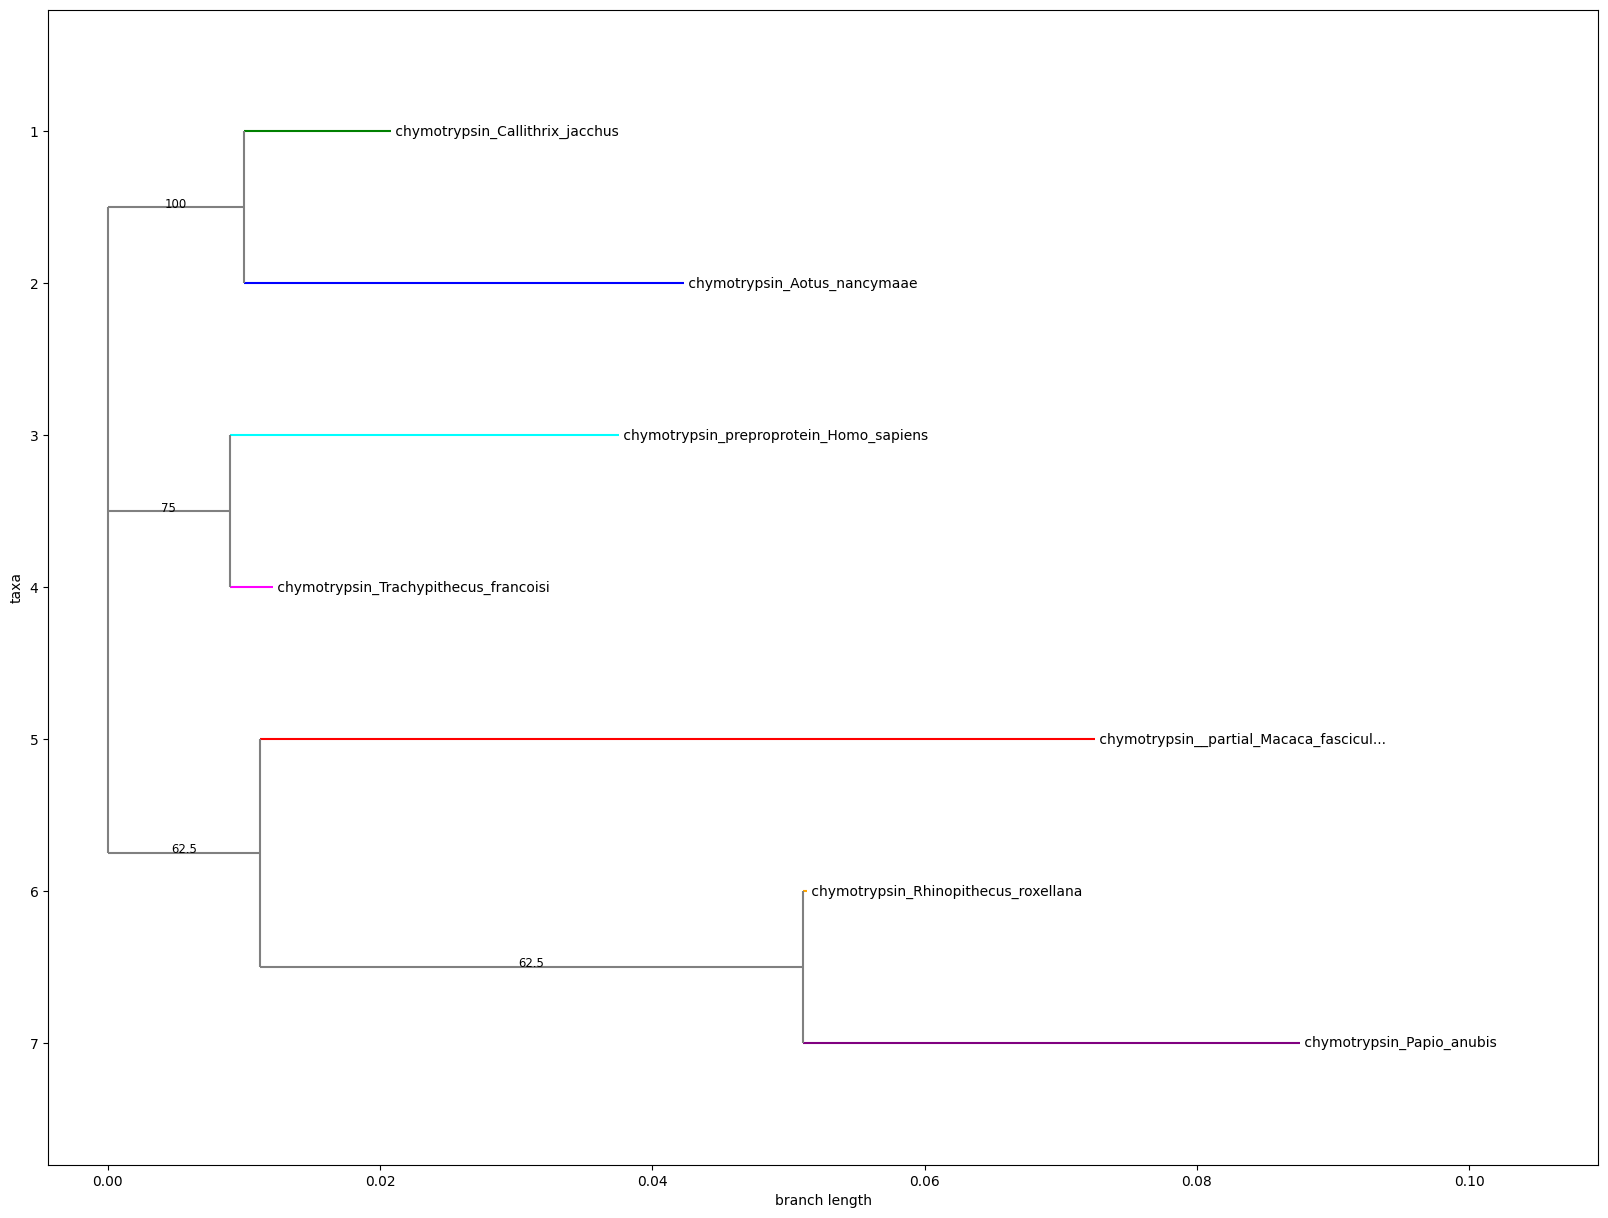

Tree saved to results/protein_consensus_colored_by_organism.png


In [149]:
color_tree(proteins_consensus_tree, "results/protein_consensus_colored_by_organism.png", organism_colors)


### based on proteins

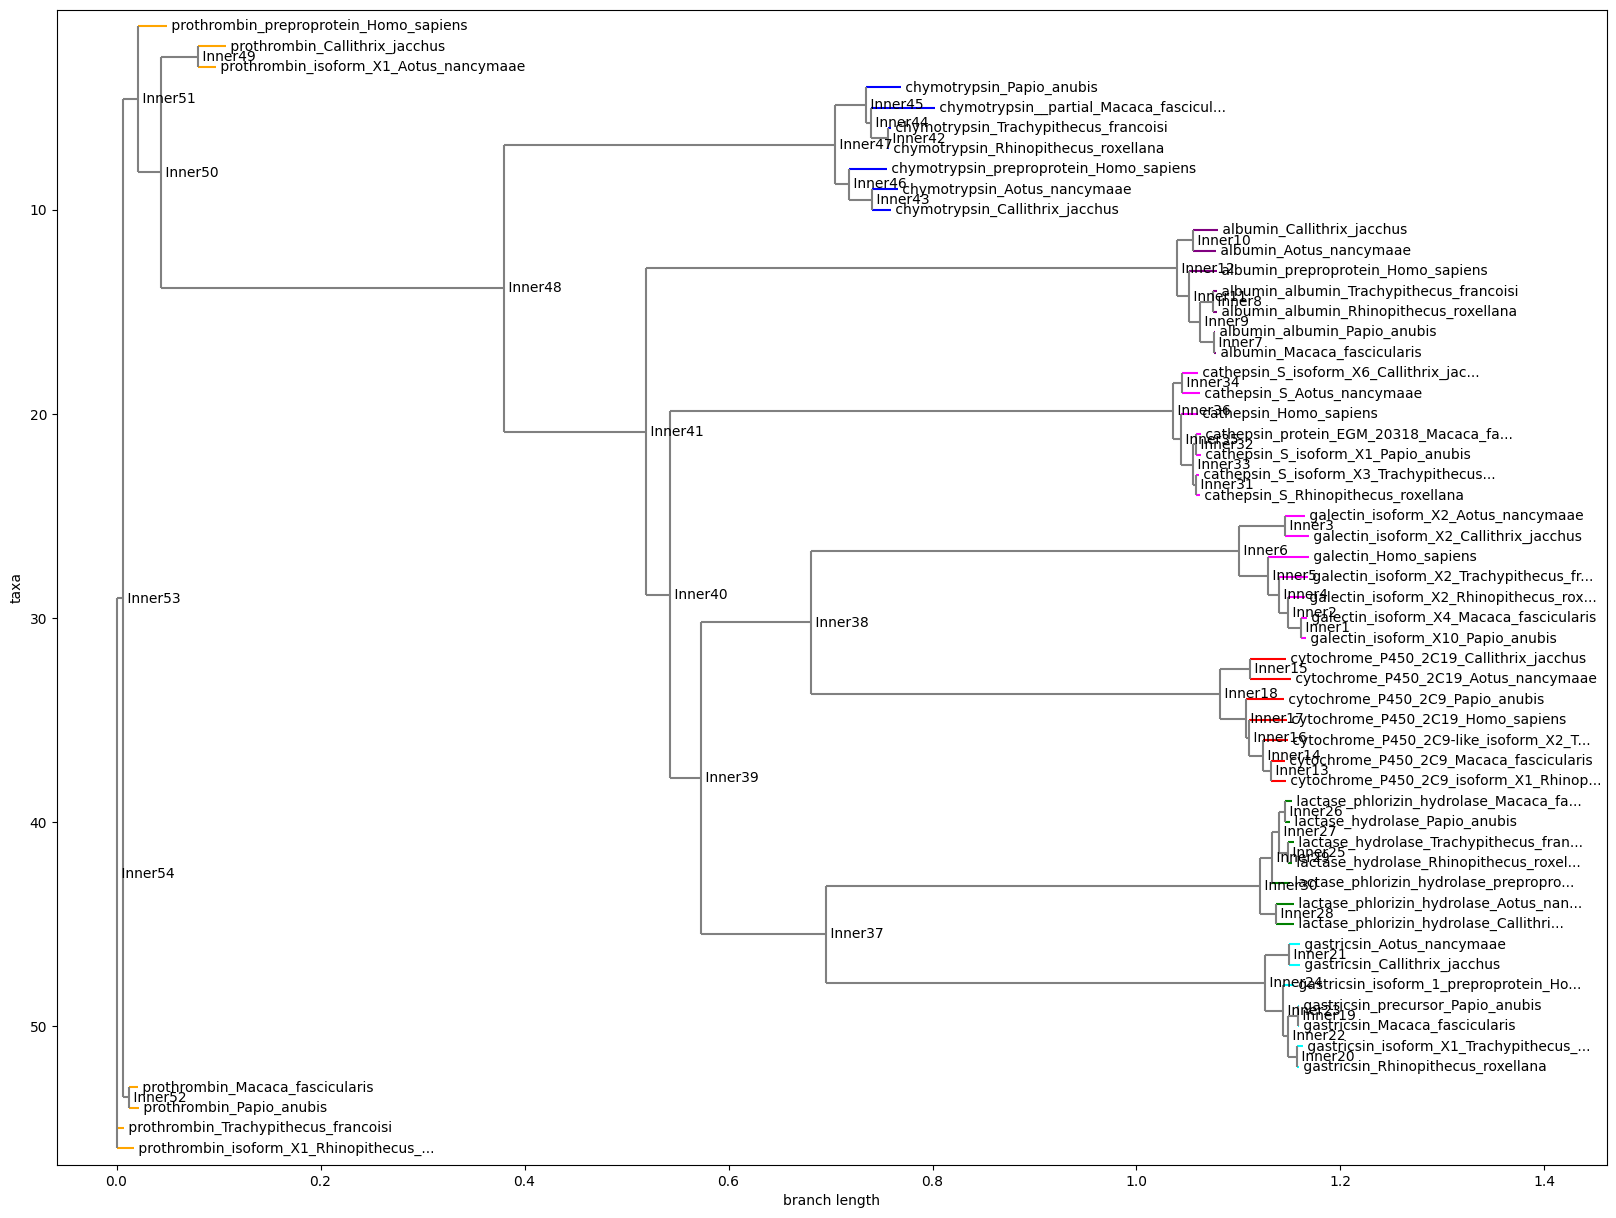

Tree saved to results/all_sequences_colored_by_protein.png


In [150]:
color_tree(all_sequences_tree, "results/all_sequences_colored_by_protein.png", protein_group_colors)

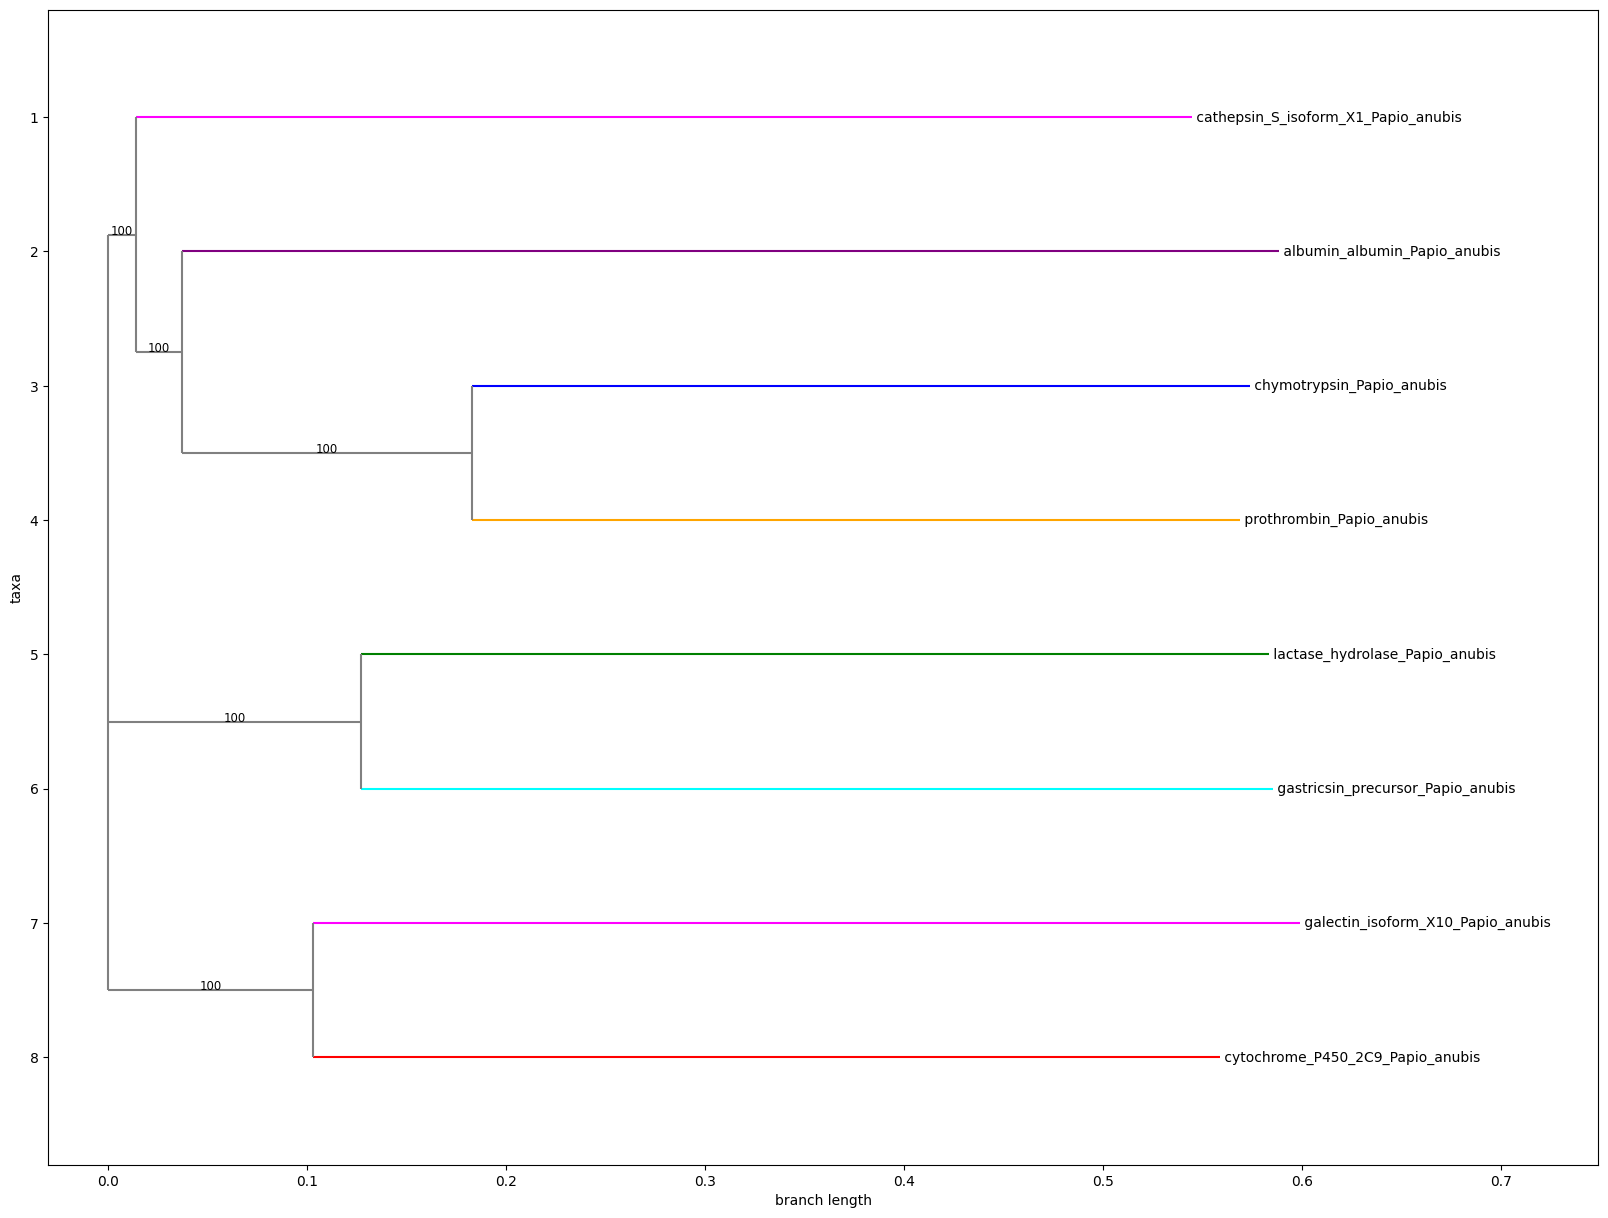

Tree saved to results/species_consensus_colored_by_protein.png


In [151]:
color_tree(species_consensus_tree, "results/species_consensus_colored_by_protein.png", protein_group_colors)

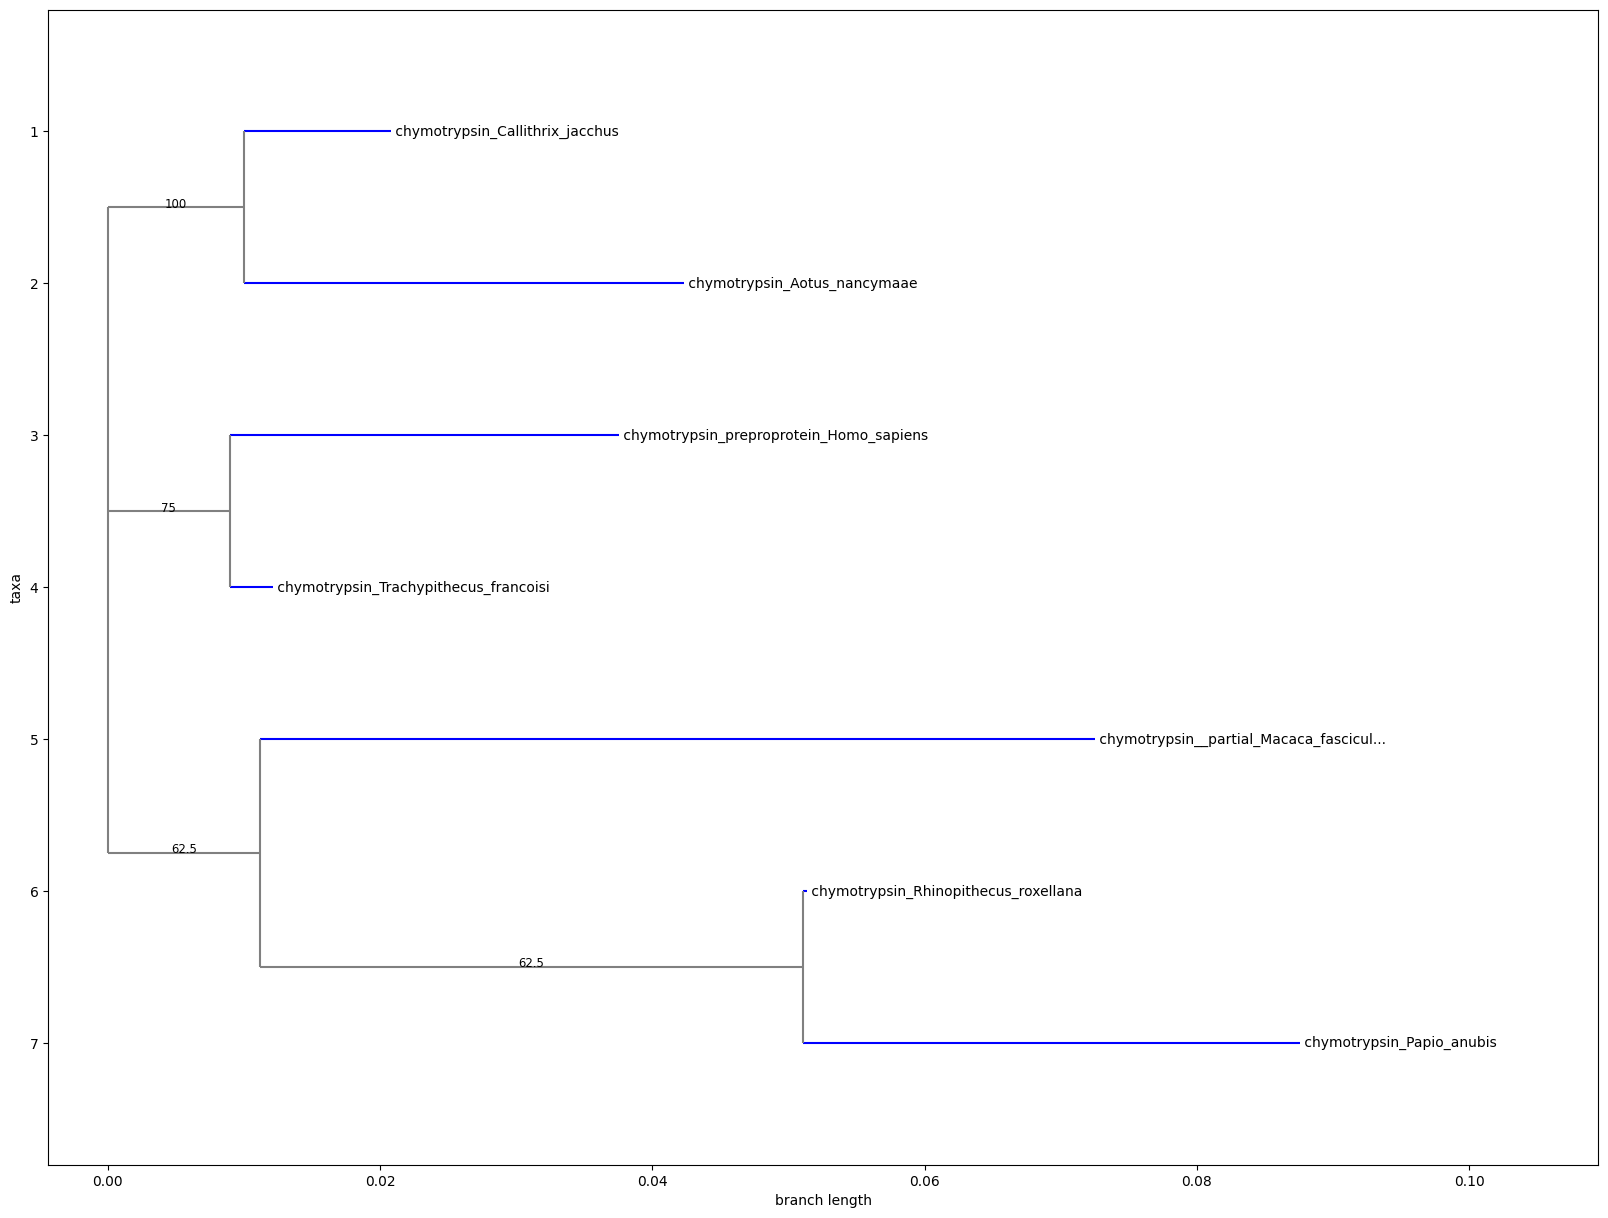

Tree saved to results/protein_consensus_colored_by_protein.png


In [152]:
color_tree(proteins_consensus_tree, "results/protein_consensus_colored_by_protein.png", protein_group_colors)